# Exercice bonus: Reconnaissance d'image

On se propose d'exploiter un jeu de données de 1596 images naturelles en JPG représentant des chats (590 images), des fleurs (521 images) et des voitures (485 images) pour prédire le contenu de nouvelles images appartenant à ces 3 types.

Pour des raisons pédagogiques et matérielles, nous avons choisis d'utiliser Pytorch, en s'appuyant sur le cours de l'intervenant Francisco Massa, de Facebook AI Research.

## Installation des packages

In [1]:
!pip3 install torch torchvision
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
from torchvision import transforms, datasets

from google.colab import drive
drive.mount('data')

Drive already mounted at data; to attempt to forcibly remount, call drive.mount("data", force_remount=True).


## Preprocessing

Les images sont de tailles différentes, les images de voitures sont toutes carrées alors que les fleurs et les chats sont de tailles variables. Nous voulons donc les découper toutes à la même taille et normaliser les couleurs en déclarant `normalize` et `data_transform`.

In [0]:
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
data_transform = transforms.Compose([
    transforms.RandomResizedCrop(256),
    transforms.ToTensor(),
    normalize
])

On utilise le DataLoader de pytorch pour optimisé pour récupérer dynamiquement de larges jeux de données. Même si le nombre de d'images est assez petit, le jeu de données pourra être élargit.

Préalablement, les images ont été séparées en un ensemble d'apprentissage et de test, en prenant 50 images par classes pour l'ensemble de test.

In [0]:
ccf_train_dataset = datasets.ImageFolder(root='data/My Drive/UTC/SY19/images_train/',
                                           transform=data_transform)
trainloader = torch.utils.data.DataLoader(ccf_train_dataset,
                                             batch_size=1, shuffle=True,
                                             num_workers=4)
ccf_test_dataset = datasets.ImageFolder(root='data/My Drive/UTC/SY19/images_test/',
                                           transform=data_transform)
testloader = torch.utils.data.DataLoader(ccf_test_dataset,
                                             batch_size=1, shuffle=True,
                                             num_workers=4)
classes = ['car', 'cat', 'flower']

Nous pouvons vérifier le fonctionnement du trainloader.

In [4]:
dataiter = iter(trainloader)
images, labels = dataiter.next()
print(images.shape)
print(labels)

torch.Size([1, 3, 256, 256])
tensor([2])


Nous récupérons bien des images carrées de 256*256 pixels, codées sur 3 couleurs. On se propose de l'afficher.

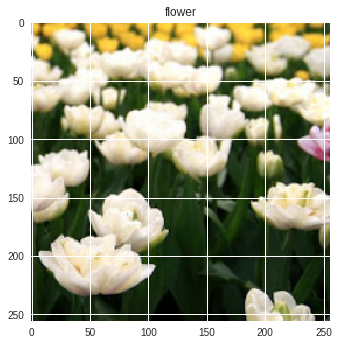

In [5]:

# Afficher une image
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
# inputs contains 4 images because batch_size=4 for the dataloaders
inputs, labels = next(iter(trainloader))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=classes[labels])


## CNN

- Define the neural network that has some learnable parameters (or weights)
- Iterate over a dataset of inputs
- Process input through the network
- Compute the loss (how far is the output from being correct)
- Propagate gradients back into the network’s parameters
- Update the weights of the network, typically using a simple update rule: weight = weight - learning_rate * gradient

## Définition du Réseau de Neuronnes Convolutif.

Notre réseau de neuronnes doit comporter des couches convolutives, qui permettent d'interpréter les formes à différentes échelles. Il doit ensuite comporter des couches linéaires pour interprèter les les sorties des couches convolutives, et associer les bonnes classes. 

Nous proposons un réseau de neuronnes à 3 couches convolutives, avec un kernel de taille 5, et 3 couches linéraires. Entre les couches convolutives, on introduit des Pools, pour réduire la taille spatiale de la représentation. 

On définit implémente la fonction forward, qui définit la circulation avant des données dans le réseaux.


In [0]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=6, kernel_size=5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=12, kernel_size=5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv3 = nn.Conv2d(in_channels=12, out_channels=16, kernel_size=5)
        self.fc1 = nn.Linear(16 * 28 * 28, 1200)
        self.fc2 = nn.Linear(1200, 120)
        self.fc3 = nn.Linear(120, 3)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        #print(x.shape)
        x = x.view(-1, 16 * 28 * 28)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()

### Optimisation

Nous définissons premièrement la fonction de perte d'entropie croisée, répandue pour les réseaux de neuronne, puis la descente de gradient stochastique, utilisée pour la rétropropagation.

On décide d'utiliser un GPU pour accélérer l'apprentissage en distribuant le calcul. 

In [7]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

GPU = True
if GPU and torch.cuda.is_available():
  net.cuda()
  print("GPU ON")

GPU ON


## Apprentissage du réseau

Le jeu de données étant limité, nous allons le parcourir un grand nombre de fois pour l'apprentissage. 

In [8]:
print("Début de l'apprentissage")

losses = []
for epoch in range(100):  # On boucle plusieurs fois sur le dataset

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        if GPU:
          inputs, labels = inputs.cuda(), labels.cuda()

        # Remettre les paramètres du gradient à 0
        optimizer.zero_grad()

        # Forward
        outputs = net(inputs)
        loss = criterion(outputs, labels) 
        
        # Backward
        loss.backward()
        
        # Optimisation
        optimizer.step()
        
        # Récupération des statistiques
        running_loss += loss.item()
        if i % 50 == 49:    # On enregistre toutes les 50 itérations.   
            losses.append(running_loss/50)
            running_loss = 0.0

print("Fin d'apprentissage")


Début de l'apprentissage
Fin d'apprentissage


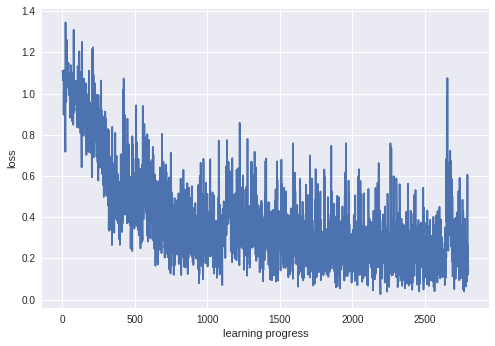

In [9]:

plt.xlabel('learning progress')
plt.ylabel('loss')
plt.plot(losses)

### Test

Enfin on test notre réseau sur le jeu de test.

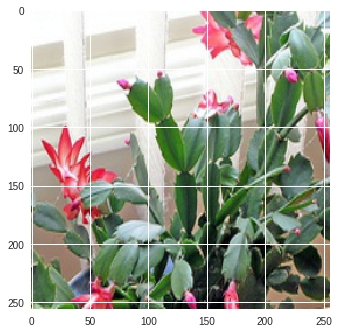

Truth: flower
Prediction: flower


In [10]:
# Test du réseau sur une image
dataiter = iter(testloader)
images, labels = dataiter.next()

imshow(torchvision.utils.make_grid(images))
print(f'Truth: {classes[labels]}')
if GPU:
  images, labels = images.cuda(), labels.cuda()
outputs = net(images)
_, predicted = torch.max(outputs, 1)
print(f'Prediction: {classes[predicted]}')

In [11]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        if GPU:
          images, labels = images.cuda(), labels.cuda()
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        total += 1
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 150 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 150 test images: 90 %


Nous atteignons une précision de 90% sur l'ensemble de test. Ce qui démontre que le réseau de neuronne est fonctionnel, mais pourrait être amélioré en précision. Notamment en travaillant sur le jeu de données. Nous pourrions par exemple multiplier chaque image en les faisant varier en translation et en rotation, ce qui augmenterait la taille du jeu de données et limiterait le surrapprentissage lié à la répétition.

Concernant le réseau, plusieurs architecture ont été testées, il est cependant difficile de trouver la dimension parfaite. 